# Generating data

In [1]:
# Activate working environment
using Pkg; Pkg.activate("../")

  Activating project at `~/AI_User_apps/AI`


In [2]:
# using Pkg; Pkg.add("Plots")
# using Pkg; Pkg.add("Flux")
# using Pkg; Pkg.add("ProgressMeter")

In [3]:
using Random 
using Plots
# using ScikitLearn
using Statistics
using Flux, ProgressMeter

For this first example, we will use the Friedman #1 regression function which takes the form: $$f(x)=10sin(\pi x_1 x_2)+ 20(x_3−0.5)^2+10x_4 + 5x_5+ N(0,\sigma) $$

In the following distribution, we will create output with 9 features despite the Friedman #1 function only depending upon the first 5 features.

In [4]:
function make_friedman1(n_samples::Int64, n_features::Int64, noise::Float64, random_state::Int64)
    rng = Random.seed!(random_state)
    X = rand(rng, Float32, (n_samples, n_features))
    y = Array{Float32}(undef, (n_samples, 1))
    @. y = 10sin(π*X[:, 1]*X[:, 2]) + 20(X[:, 3]-0.5)^2 + 10X[:, 4] + 5X[:, 5] 
    y.+= noise.*randn(rng, Float32, (n_samples, 1))
    return (X, y)
end

make_friedman1 (generic function with 1 method)

In [5]:
# Create a non-linear distribution using the Friedman #1 function
n_samples = 1000
n_feats = 9
x, y = make_friedman1(n_samples, n_feats, 0.0, 42)
println(size(x), size(y))

(1000, 9)(1000, 1)


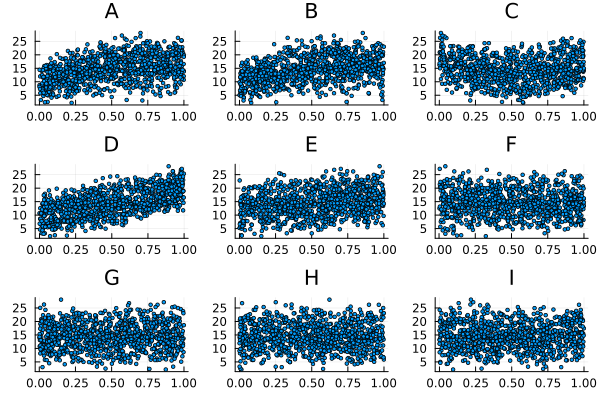

In [6]:
# Visualize the data using a mosaic plot
titles = permutedims(collect('A':'I'))
scatter(x, y, markersize=2, layout=9, legend=false, title=titles)

# Preprocessing the data
Most ML problems optimally operate on data that is normalized. The type optimal type of normalization depends upon the structure of the data and the desired output.

For this data, we will use a rather standard that shifts and scales the data to a distribution centered around 0 with a standard deviation equal to 1.

$$ x' = \frac{x - \mu(x)}{\sigma(x)}$$

We can do this manually or use a built-in function provided as a part of TensorFlow. It is often useful to also create an inverse normalization function, which can be used to convert the ML model predictions back to the physical space.

In [7]:
function normalize(X)
    μ = mean(X, dims=1)
    σ = stdm(X, μ, dims=1)
    X_normalized = (X.-μ)./σ
    return X_normalized, μ, σ
end

inverse_normalize(X_normalized, μ, σ) = X_normalized.*σ.+μ;

In [8]:
x_norm, x_mean, x_std = normalize(x);
y_norm, y_mean, y_std = normalize(y);

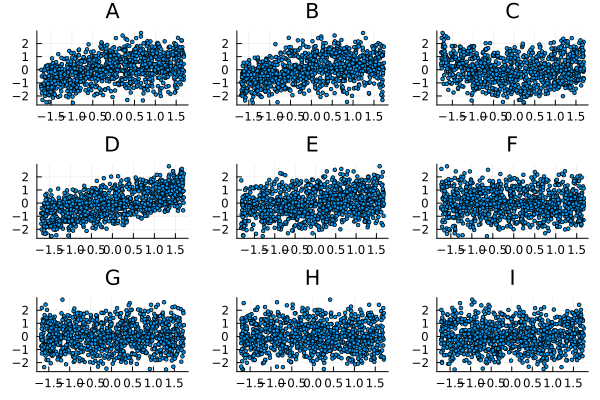

In [9]:
# Visualize the normalized data 
scatter(x_norm, y_norm, markersize=2, layout=9, legend=false, title=titles)

# Creating an ML Model
Now that the data is preprocessed nicely, let's create a standard feed-forward neural network and train it to learn the relationship between the features (x) and the output (y).

The initial model will have an input layer, three hidden layers with 64 neurons, and an output layer. The number of hidden layers, neurons per layer, and a variety of other so-called "hyperparameters" will have a noticeable impact on model results. These values require extensive tuning depending on the problem at hand.

In [10]:
x_train = transpose(x_norm) # takes data of shape (n_feats, n_samples)
y_train = transpose(y_norm)

# Define our model, a multi-layer perceptron with 3 hidden layers of size 64:
model = Chain(
    Dense(n_feats => 64, relu),   # activation function inside layer
    Dense(64 => 64, relu),
    Dense(64 => 64, relu),
    Dense(64 => 1))

Chain(
  Dense(9 => 64, relu),                 # 640 parameters
  Dense(64 => 64, relu),                # 4_160 parameters
  Dense(64 => 64, relu),                # 4_160 parameters
  Dense(64 => 1),                       # 65 parameters
)                   # Total: 8 arrays, 9_025 parameters, 35.754 KiB.

In [11]:
# To train the model, we use batches of 32 samples, and one-hot encoding:
loader = Flux.DataLoader((x_train, y_train), batchsize=32, shuffle=true);

optim = Flux.setup(Flux.Adam(1e-3), model)  # will store optimiser momentum, etc.

# Training loop, using the whole data set 100 times:
losses = []
@showprogress for epoch in 1:100
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.mse(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [12]:
out = model(x_train)  # first row is prob. of true, second row p(false)

1×1000 Matrix{Float32}:
 1.26948  -1.05507  0.601868  1.5917  …  0.703844  0.242734  -1.63312

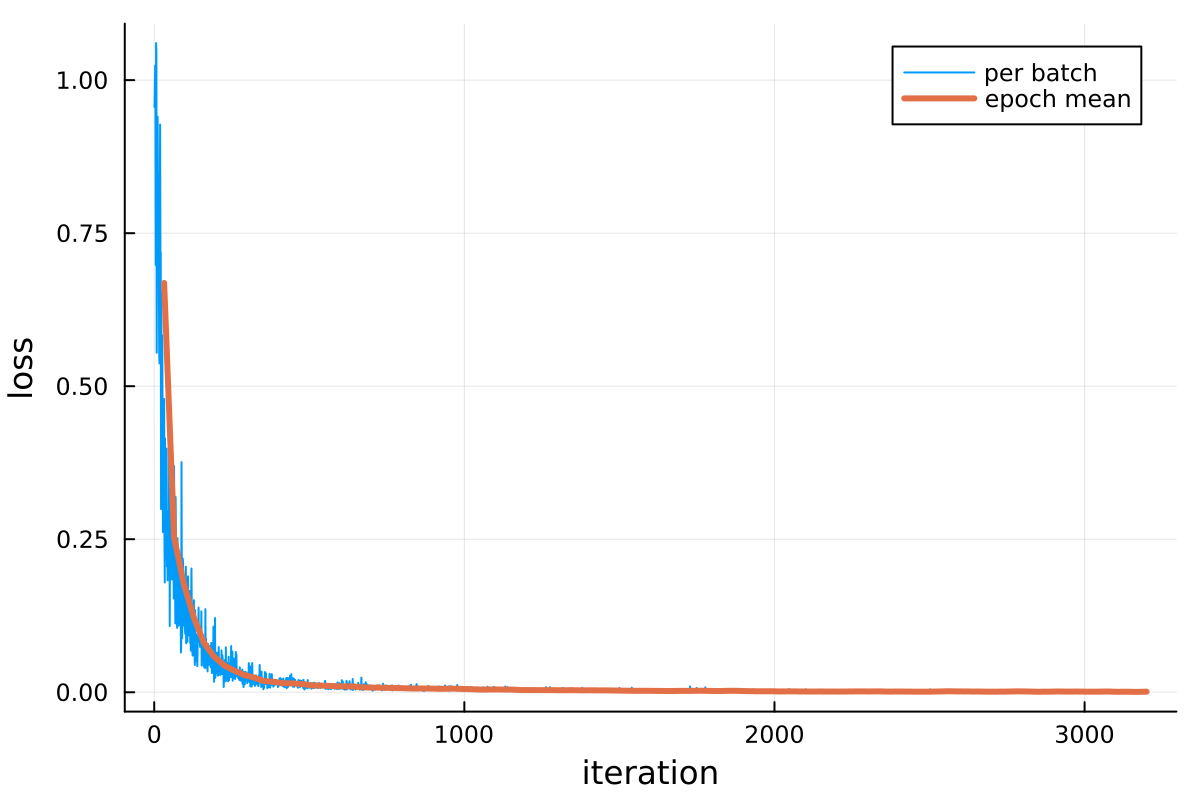

In [14]:
plot(losses; xaxis=("iteration"), yaxis="loss", label="per batch")
n = length(loader)
plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)), label="epoch mean", linewidth=3, dpi=200)